Importing all needed packages and loading in the data. We apply the mapping for the grades and split it where neccesary. We also convert all categorical data to numerical data by creating 'dummies'. The first dummie is always dropped as it is encoded in the other dummies being zero.

In [110]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from sklearn import preprocessing
from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d

dMat = pd.read_csv('Data/student-mat.csv')
dPor = pd.read_csv('Data/student-por.csv')

def grade_to_class(x: int) -> int:
    if x < 10:
        return 5
    elif x < 12:
        return 4
    elif x < 14:
        return 3
    elif x < 16:
        return 2
    else:
        return 1

# Apply mapping to grades
dMat[['G1', 'G2', 'G3']] = dMat[['G1', 'G2', 'G3']].applymap(grade_to_class)
dPor[['G1', 'G2', 'G3']] = dPor[['G1', 'G2', 'G3']].applymap(grade_to_class)

# Adding course data for combining into one dataset
dMat['course'] = 'mat'
dPor['course'] = 'por'

dTot = dMat.append(dPor, ignore_index=True)

# Dropping grade1 and grade2 because they lead directly to grade3.
# Dropping grade3 because this is the value we want to predict
dTotNoGrades = dTot.drop(['G1','G2','G3'], axis=1) 

# Dropping the nominal columns
dTotNoNom = dTot.drop(['Mjob','Fjob','reason','guardian'], axis=1)

# Converting categorical columns to numerical values using 'dummies'
dTot = pd.get_dummies(dTot, prefix_sep='_', drop_first=True)
dTotNoGrades = pd.get_dummies(dTotNoGrades, prefix_sep='_', drop_first=True)
dTotNoNom = pd.get_dummies(dTotNoNom, prefix_sep='_', drop_first=True)

display(dTot)

age  Medu  Fedu  traveltime  studytime  failures  famrel  freetime  \
0      18     4     4           2          2         0       4         3   
1      17     1     1           1          2         0       5         3   
2      15     1     1           1          2         3       4         3   
3      15     4     2           1          3         0       3         2   
4      16     3     3           1          2         0       4         3   
...   ...   ...   ...         ...        ...       ...     ...       ...   
1039   19     2     3           1          3         1       5         4   
1040   18     3     1           1          2         0       4         3   
1041   18     1     1           2          2         0       1         1   
1042   17     3     1           2          1         0       2         4   
1043   18     3     2           3          1         0       4         4   

      goout  Dalc  ...  guardian_other  schoolsup_yes  famsup_yes  paid_yes  \
0         4     1  ...               0              1           0         0   
1         3     1  ...               0              0           1         0   
2         2     2  ...               0              1           0         1   
3         2     1  ...               0              0           1         1   
4         2     1  ...               0              0           1         1   
...     ...   ...  ...             ...            ...         ...       ...   
1039      2     1  ...               0              0           0         0   
1040      4     1  ...               0              0           1         0   
1041      1     1  ...               0              0           0         0   
1042      5     3  ...               0              0           0         0   
1043      1     3  ...               0              0           0         0   

      activities_yes  nursery_yes  higher_yes  internet_yes  romantic_yes  \
0                  0            1           1             0             0   
1                  0            0           1             1             0   
2                  0            1           1             1             0   
3                  1            1           1             1             1   
4                  0            1           1             0             0   
...              ...          ...         ...           ...           ...   
1039               1            0           1             1             0   
1040               0            1           1             1             0   
1041               1            1           1             0             0   
1042               0            0           1             1             0   
1043               0            0           1             1             0   

      course_por  
0              0  
1              0  
2              0  
3              0  
4              0  
...          ...  
1039           1  
1040           1  
1041           1  
1042           1  
1043           1  

[1044 rows x 43 columns]

To get a first impression on the relations within the dataset, we first plot a correlation matrix of all non nominal data.

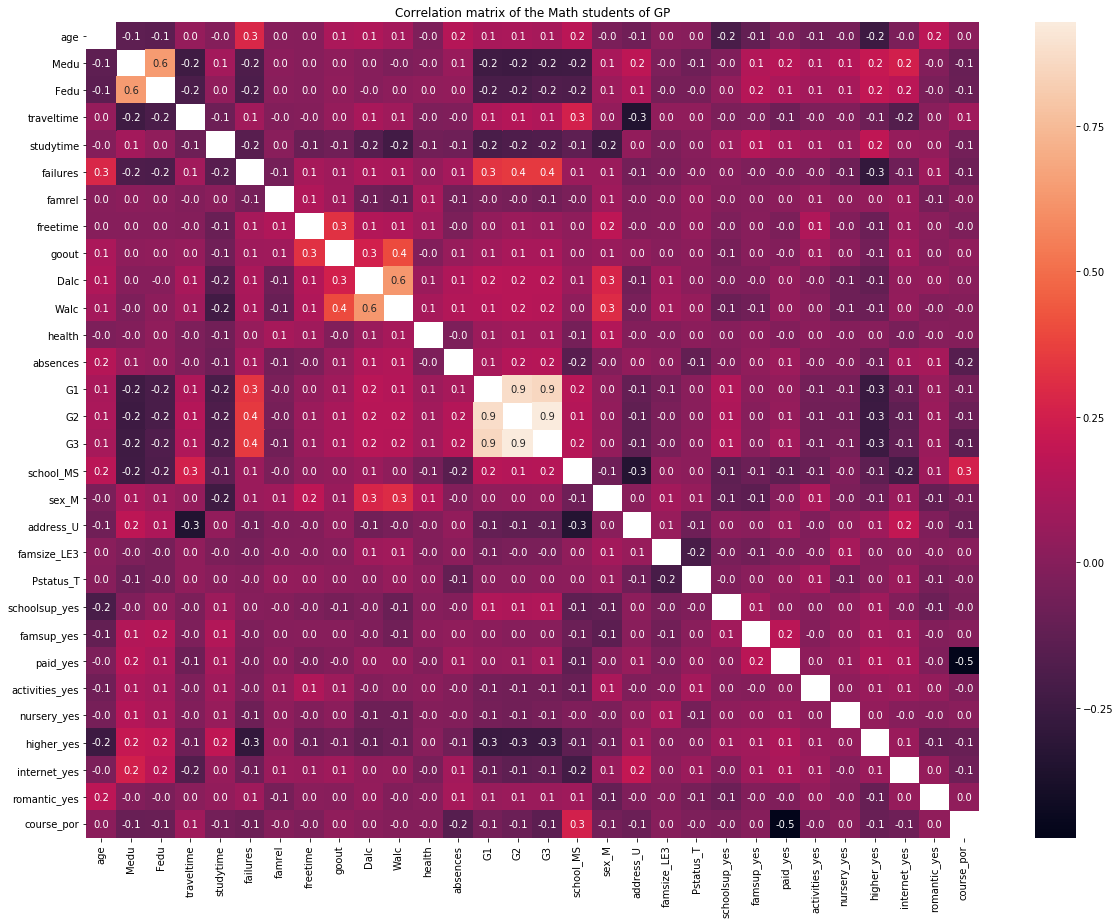

In [111]:
# Found on https://stackoverflow.com/questions/24475094/set-values-on-the-diagonal-of-pandas-dataframe
def pd_fill_diagonal(df_matrix, value=0): 
    mat = df_matrix.values
    n = mat.shape[0]
    mat[range(n), range(n)] = value
    return pd.DataFrame(mat, columns=df_matrix.columns, index=df_matrix.index)

plt.figure(figsize=(20,15))
plt.title('Correlation matrix of the Math students of GP')
dTotCor = dTotNoNom.corr()
sb.heatmap(pd_fill_diagonal(dTotCor, np.NaN), annot=True, fmt=".1f")


# Fix found on [https://github.com/mwaskom/seaborn/issues/1773] for bug that cut off top and bottom of heatmap
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da!

Let's now plot boxplots of the attributes to see the division of the values. The values found on the y-axis are taken directly from the descriptions provided about the attributes in the paper.

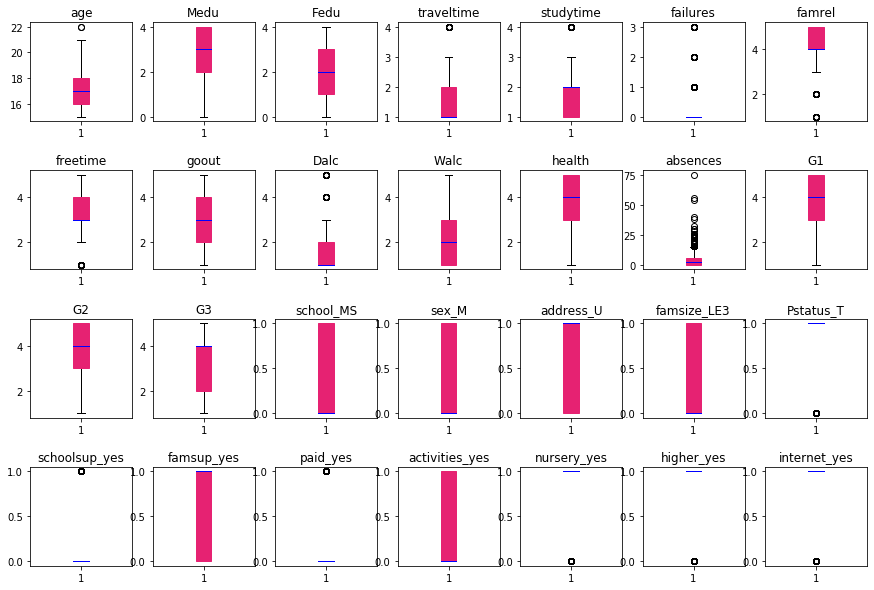

In [112]:
c = '#e62272'
fig, axs = plt.subplots(4,7, figsize=(15,10))
for i in range(28):
    plt.sca(axs[int(i/7),i%7])
    plt.title(dTotNoNom.columns[i])
    plt.boxplot(dTotNoNom.iloc[:,i], patch_artist=True, boxprops=dict(facecolor=c, color=c),
               medianprops=dict(color='blue'))
    plt.subplots_adjust(hspace = .5)

There are some boxplots that seem interesting, so we now make histograms of those attributes.

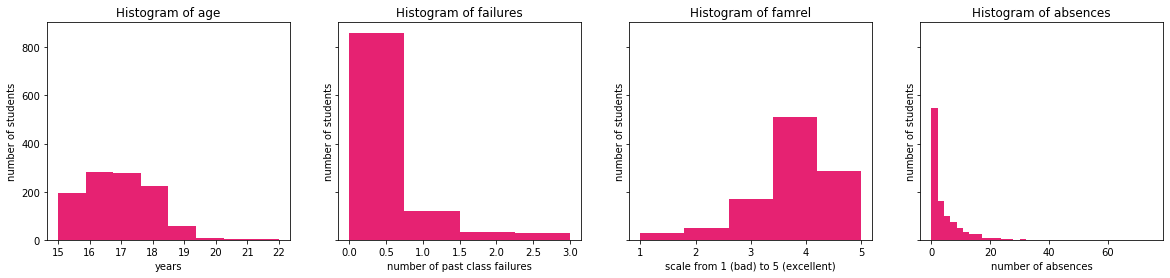

In [113]:
dTotHist = dTot[['age', 'failures', 'famrel', 'absences']]
xlabels = ['years', 'number of past class failures', 'scale from 1 (bad) to 5 (excellent)', 'number of absences', 'grade from 1 (excellent) to 5 (fail)']

fig, axs = plt.subplots(1,4,False,True, figsize=(20,4))
for i in range(4):
    plt.sca(axs[i])
    plt.title('Histogram of ' + dTotHist.columns[i])
    plt.xlabel(xlabels[i])
    plt.ylabel('number of students')
    plt.hist(dTotHist.iloc[:,i], len(dTotHist.iloc[:,i].unique()), color='#e62272')

We also plot the distribution of the grades for every group

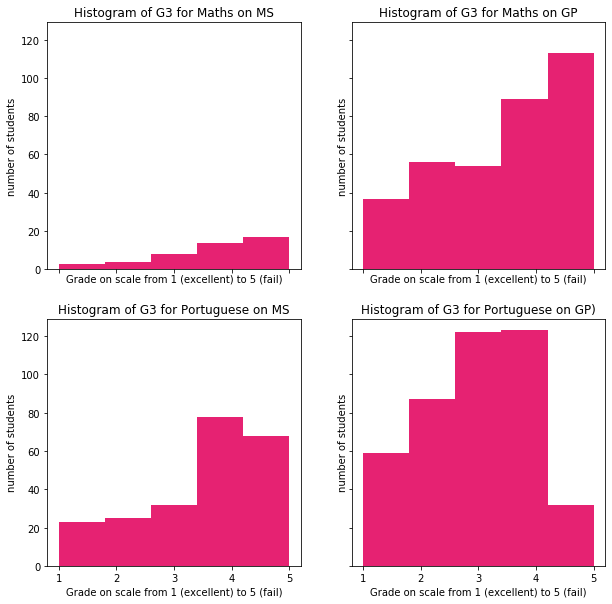

In [114]:
dMat = dTot[dTot['course_por'] == 0].drop(['course_por'], axis=1)
dPor = dTot[dTot['course_por'] == 1].drop(['course_por'], axis=1)

dMatMS = dMat[dMat['school_MS'] == 1].drop(['school_MS'], axis=1)
dMatGP = dMat[dMat['school_MS'] == 0].drop(['school_MS'], axis=1)

dPorMS = dPor[dPor['school_MS'] == 1].drop(['school_MS'], axis=1)
dPorGP = dPor[dPor['school_MS'] == 0].drop(['school_MS'], axis=1)

ds = [(dMatMS, 'Maths on MS'), (dMatGP, 'Maths on GP'), 
      (dPorMS, 'Portuguese on MS'), (dPorGP, 'Portuguese on GP)')]

fig, axs = plt.subplots(2,2,True,True, figsize=(10,10))
for i, t in enumerate(ds):
    d, n = t
    plt.sca(axs[int(i/2), i % 2])
    plt.title(f'Histogram of G3 for {n}')
    plt.xlabel('Grade on scale from 1 (excellent) to 5 (fail)')
    plt.ylabel('number of students')
    plt.hist(d['G3'], 5, color='#e62272')

As we now have gathered a first impression of our data, we will normalise the data.

In [115]:
dTotNorm = pd.DataFrame(preprocessing.normalize(dTotNoGrades.drop(['school_MS', 'course_por'], axis=1)), columns=dTotNoGrades.drop(['school_MS', 'course_por'], axis=1).columns)

display(dTotNorm)

age      Medu      Fedu  traveltime  studytime  failures    famrel  \
0     0.841085  0.186908  0.186908    0.093454   0.093454  0.000000  0.186908   
1     0.881409  0.051848  0.051848    0.051848   0.103695  0.000000  0.259238   
2     0.747203  0.049814  0.049814    0.049814   0.099627  0.149441  0.199254   
3     0.843816  0.225018  0.112509    0.056254   0.168763  0.000000  0.168763   
4     0.839782  0.157459  0.157459    0.052486   0.104973  0.000000  0.209946   
...        ...       ...       ...         ...        ...       ...       ...   
1039  0.864530  0.091003  0.136505    0.045502   0.136505  0.045502  0.227508   
1040  0.890043  0.148340  0.049447    0.049447   0.098894  0.000000  0.197787   
1041  0.891133  0.049507  0.049507    0.099015   0.099015  0.000000  0.049507   
1042  0.826568  0.145865  0.048622    0.097243   0.048622  0.000000  0.097243   
1043  0.844782  0.140797  0.093865    0.140797   0.046932  0.000000  0.187729   

      freetime     goout      Dalc  ...  guardian_mother  guardian_other  \
0     0.140181  0.186908  0.046727  ...         0.046727             0.0   
1     0.155543  0.155543  0.051848  ...         0.000000             0.0   
2     0.149441  0.099627  0.099627  ...         0.049814             0.0   
3     0.112509  0.112509  0.056254  ...         0.056254             0.0   
4     0.157459  0.104973  0.052486  ...         0.000000             0.0   
...        ...       ...       ...  ...              ...             ...   
1039  0.182006  0.091003  0.045502  ...         0.045502             0.0   
1040  0.148340  0.197787  0.049447  ...         0.049447             0.0   
1041  0.049507  0.049507  0.049507  ...         0.049507             0.0   
1042  0.194487  0.243108  0.145865  ...         0.048622             0.0   
1043  0.187729  0.046932  0.140797  ...         0.046932             0.0   

      schoolsup_yes  famsup_yes  paid_yes  activities_yes  nursery_yes  \
0          0.046727    0.000000  0.000000        0.000000     0.046727   
1          0.000000    0.051848  0.000000        0.000000     0.000000   
2          0.049814    0.000000  0.049814        0.000000     0.049814   
3          0.000000    0.056254  0.056254        0.056254     0.056254   
4          0.000000    0.052486  0.052486        0.000000     0.052486   
...             ...         ...       ...             ...          ...   
1039       0.000000    0.000000  0.000000        0.045502     0.000000   
1040       0.000000    0.049447  0.000000        0.000000     0.049447   
1041       0.000000    0.000000  0.000000        0.049507     0.049507   
1042       0.000000    0.000000  0.000000        0.000000     0.000000   
1043       0.000000    0.000000  0.000000        0.000000     0.000000   

      higher_yes  internet_yes  romantic_yes  
0       0.046727      0.000000      0.000000  
1       0.051848      0.051848      0.000000  
2       0.049814      0.049814      0.000000  
3       0.056254      0.056254      0.056254  
4       0.052486      0.000000      0.000000  
...          ...           ...           ...  
1039    0.045502      0.045502      0.000000  
1040    0.049447      0.049447      0.000000  
1041    0.049507      0.000000      0.000000  
1042    0.048622      0.048622      0.000000  
1043    0.046932      0.046932      0.000000  

[1044 rows x 38 columns]

And let's now apply PCA on the normalised data, and plot the first three Principal Components.

variance explained per pca: 


array([5.47022805e-01, 6.70560550e-02, 6.53518521e-02, 5.54873209e-02,
       3.55130630e-02, 2.28453337e-02, 2.19779228e-02, 1.87405161e-02,
       1.53737803e-02, 1.43169635e-02, 1.38144472e-02, 1.17188247e-02,
       1.01294961e-02, 9.53841519e-03, 7.63913637e-03, 7.02690384e-03,
       6.92467916e-03, 6.45599920e-03, 6.35869688e-03, 6.07508416e-03,
       5.43406136e-03, 4.79396821e-03, 4.51978157e-03, 4.18641672e-03,
       4.09302288e-03, 3.97922739e-03, 3.65675597e-03, 3.36431795e-03,
       2.82724065e-03, 2.71825243e-03, 2.38131948e-03, 2.13462637e-03,
       1.74482540e-03, 1.71319437e-03, 1.20574941e-03, 9.82169234e-04,
       5.87250044e-04, 3.10525523e-04])

variance explained by the first 13 PCAs:  0.8993483802486055


pca_0     pca_1     pca_2     pca_3     pca_4     pca_5     pca_6  \
0     0.078748 -0.099209  0.001425  0.036219  0.013738 -0.028995  0.019430   
1     0.000349  0.014844 -0.112292 -0.041983  0.057618 -0.014973 -0.035909   
2     0.322659  0.078317 -0.051245 -0.030459 -0.006543  0.034589 -0.020613   
3    -0.089619 -0.105076  0.045576 -0.093789 -0.052472 -0.062425  0.032409   
4     0.004302 -0.048096  0.045488 -0.085679 -0.020866  0.002136  0.000252   
...        ...       ...       ...       ...       ...       ...       ...   
1039 -0.025714 -0.021162 -0.020265 -0.082729  0.008986  0.023646  0.003039   
1040 -0.002709 -0.038478 -0.117845  0.089781  0.034823 -0.031324  0.007881   
1041  0.104020  0.010314 -0.129705 -0.149443 -0.138454 -0.035702  0.090193   
1042  0.108161  0.123597  0.011960  0.132432 -0.020574 -0.001800  0.061977   
1043 -0.008881  0.071185  0.039794 -0.050139 -0.083453  0.112535 -0.017554   

         pca_7     pca_8     pca_9  ...    pca_29    pca_30    pca_31  \
0    -0.062633  0.028803 -0.028163  ... -0.025017  0.032659  0.005241   
1    -0.008076 -0.046026 -0.001559  ...  0.001123 -0.003775  0.006776   
2     0.036433 -0.041194  0.013384  ...  0.014187 -0.011384 -0.002036   
3     0.046161 -0.019045  0.011171  ...  0.042896  0.011657  0.001464   
4    -0.000125 -0.030316 -0.025688  ...  0.000489 -0.016249 -0.004777   
...        ...       ...       ...  ...       ...       ...       ...   
1039  0.027188 -0.029208 -0.010278  ...  0.005018  0.002898 -0.005377   
1040 -0.022131 -0.047254  0.002856  ... -0.018499 -0.016987  0.011748   
1041 -0.021188  0.010066 -0.034730  ...  0.003656 -0.006308  0.003035   
1042 -0.011178 -0.017420 -0.023265  ...  0.003789 -0.015530  0.000264   
1043  0.025586  0.009881 -0.081204  ...  0.006294 -0.005645 -0.007888   

        pca_32    pca_33    pca_34    pca_35    pca_36    pca_37  G3  
0    -0.021626 -0.004964 -0.022063 -0.002175  0.012611 -0.007161   5  
1    -0.007153 -0.010750 -0.005035 -0.015073  0.007270 -0.004648   5  
2     0.022842 -0.011826 -0.011217 -0.001565  0.010389 -0.003049   4  
3    -0.010973  0.007419 -0.014246  0.002999 -0.005217 -0.000795   2  
4     0.008437  0.004152 -0.003545 -0.009840  0.000492 -0.000596   4  
...        ...       ...       ...       ...       ...       ...  ..  
1039 -0.009963 -0.004587  0.001698 -0.005562 -0.007392  0.003124   4  
1040  0.000904 -0.007204  0.003061 -0.001529 -0.009245 -0.001477   1  
1041 -0.008191 -0.004553  0.001610 -0.000438 -0.009330 -0.000716   5  
1042 -0.014526 -0.005790  0.005176  0.001970  0.002334 -0.003772   4  
1043 -0.018577 -0.000838  0.006023 -0.000049 -0.000063  0.001261   4  

[1044 rows x 39 columns]

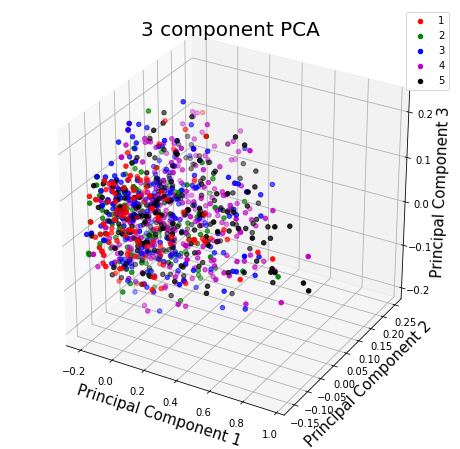

In [116]:
pca = PCA(svd_solver='full')
dTotPCA = pca.fit_transform(dTotNorm)
pca_cols = [f'pca_{x}' for x in range(pca.n_components_)]

print("variance explained per pca: ")
display(pca.explained_variance_ratio_)
print("variance explained by the first 13 PCAs: ", sum(pca.explained_variance_ratio_[:13]))

dTotPCA = pd.DataFrame(dTotPCA, columns=pca_cols)

dTotPCAGrades = pd.concat([dTotPCA, dTot[['G3']]], axis=1)
display(dTotPCAGrades)

fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection='3d')
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('3 component PCA', fontsize = 20)
targets = [1, 2, 3, 4, 5]
colors = ['r', 'g', 'b', 'm', 'black']
for target, color in zip(targets,colors):
    indicesToKeep = dTotPCAGrades['G3'] == target
    ax.scatter(dTotPCA.loc[indicesToKeep, pca_cols[0]],
               dTotPCA.loc[indicesToKeep, pca_cols[1]],
               dTotPCA.loc[indicesToKeep, pca_cols[2]],
               c=color,
               label=str(target))
ax.legend(targets)
ax.grid()